In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, r2_score
from pmdarima import auto_arima
from prophet import Prophet
import yfinance as yf

Importing plotly failed. Interactive plots will not work.


# ABRIMOS EL DATA FRAME

In [2]:
data = pd.read_csv('SP 500 Stock Prices 2014-2017.csv')
data

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391
...,...,...,...,...,...,...,...
497467,XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677
497468,YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613
497469,ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624
497470,ZION,2017-12-29,51.2800,51.5500,50.8100,50.8300,1261916


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497472 non-null  object 
 1   date    497472 non-null  object 
 2   open    497461 non-null  float64
 3   high    497464 non-null  float64
 4   low     497464 non-null  float64
 5   close   497472 non-null  float64
 6   volume  497472 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 26.6+ MB


In [4]:
data.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


In [5]:
data.tail()

,symbol,date,open,high,low,close,volume
497467,XYL,2017-12-29,68.53,68.80,67.92,68.20,1046677
497468,YUM,2017-12-29,82.64,82.71,81.59,81.61,1347613
497469,ZBH,2017-12-29,121.75,121.95,120.62,120.67,1023624
497470,ZION,2017-12-29,51.28,51.55,50.81,50.83,1261916
497471,ZTS,2017-12-29,72.55,72.76,72.04,72.04,1704122


In [6]:
data.isnull().sum()

symbol     0
date       0
open      11
high       8
low        8
close      0
volume     0
dtype: int64

In [7]:
valores_nulos = data[data.isna().any(axis=1)]
valores_nulos

,symbol,date,open,high,low,close,volume
166348,VRTX,2015-05-12,NaN,NaN,NaN,124.0800,569747
175557,REGN,2015-06-09,NaN,NaN,NaN,526.0900,12135
182011,WRK,2015-06-26,NaN,NaN,NaN,61.9000,100
188547,DHR,2015-07-17,NaN,88.76,88.24,88.7200,2056819
188578,ES,2015-07-17,NaN,48.49,47.85,47.9200,1246786
188760,O,2015-07-17,NaN,47.31,46.83,46.9900,1229513
249223,DHR,2016-01-12,NaN,NaN,NaN,88.5500,0
249438,O,2016-01-12,NaN,NaN,NaN,52.4300,0
278801,UA,2016-04-07,NaN,NaN,NaN,41.5600,0
308365,FTV,2016-07-01,NaN,NaN,NaN,49.5400,0


In [8]:
data_limpio = data.dropna()
data_limpio

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391
...,...,...,...,...,...,...,...
497467,XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677
497468,YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613
497469,ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624
497470,ZION,2017-12-29,51.2800,51.5500,50.8100,50.8300,1261916


In [9]:
data_limpio.duplicated().sum()
data_limpio

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391
...,...,...,...,...,...,...,...
497467,XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677
497468,YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613
497469,ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624
497470,ZION,2017-12-29,51.2800,51.5500,50.8100,50.8300,1261916


In [10]:
data_limpio.describe()

,open,high,low,close,volume
count,497461.000000,497461.000000,497461.000000,497461.000000,4.974610e+05
mean,86.352275,87.132717,85.552616,86.368586,4.253695e+06
std,101.471228,102.312340,100.571231,101.471516,8.232210e+06
min,1.620000,1.690000,1.500000,1.590000,1.010000e+02
25%,41.690000,42.090000,41.280000,41.700000,1.080183e+06
50%,64.970000,65.560000,64.357400,64.980000,2.085013e+06
75%,98.410000,99.230000,97.580000,98.420000,4.271999e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [11]:
companies = data_limpio['symbol'].unique()
companies

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK',
       'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY', 'BDX',
       'BEN', 'BF.B', 'BIIB', 'BK', 'BLK', 'BLL', 'BMY', 'BRK.B', 'BSX',
       'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA', 'CBG', 'CBOE', 'CBS',
       'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN', 'CF', 'CHD', 'CHK',
       'CHRW', 'CHTR', 'CINF', 'CI', 'CLX', 'CL', 'CMA', 'CMCSA', 'CME',
       'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO',
       'COP', 'COST', 'COTY', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTL',
       'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'C', 'DAL', 'D

# LLAMADA API PARA AÑADIR LA COLUMNA SECTOR

In [12]:
# Obtener una lista única de símbolos
symbols = data_limpio['symbol'].unique()

# Crear un diccionario para almacenar el sector de cada símbolo
sector_mapping = {}

# Obtener la información de cada símbolo utilizando yfinance
for symbol in symbols:
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        sector = info.get('sector', 'Unknown')
        sector_mapping[symbol] = sector
    except Exception as e:
        print(f"Error obteniendo información para {symbol}: {e}")
        sector_mapping[symbol] = 'Unknown'

# Agregar la columna de sector al dataset
data_limpio['sector'] = data_limpio['symbol'].map(sector_mapping)

# Verificar los primeros registros para confirmar que la columna fue añadida correctamente
print(data_limpio.head())

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABC&crumb=j48Jsdb%2FKh%2F
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARNC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARNC&crumb=j48Jsdb%2FKh%2F
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ATVI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ATVI&crumb=j48Jsdb%2FKh%2F
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DISH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=fi

  symbol        date      open      high       low     close    volume  \
0    AAL  2014-01-02   25.0700   25.8200   25.0600   25.3600   8998943   
1   AAPL  2014-01-02   79.3828   79.5756   78.8601   79.0185  58791957   
2    AAP  2014-01-02  110.3600  111.8800  109.2900  109.7400    542711   
3   ABBV  2014-01-02   52.1200   52.3300   51.5200   51.9800   4569061   
4    ABC  2014-01-02   70.1100   70.2300   69.4800   69.8900   1148391   

              sector  
0        Industrials  
1         Technology  
2  Consumer Cyclical  
3         Healthcare  
4            Unknown  


C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\1081331984.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpio['sector'] = data_limpio['symbol'].map(sector_mapping)


In [13]:
data_limpio

,symbol,date,open,high,low,close,volume,sector
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,Industrials
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,Technology
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,Consumer Cyclical
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,Healthcare
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,Unknown
...,...,...,...,...,...,...,...,...
497467,XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677,Industrials
497468,YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613,Consumer Cyclical
497469,ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624,Healthcare
497470,ZION,2017-12-29,51.2800,51.5500,50.8100,50.8300,1261916,Financial Services


# ANALISIS EDA

In [14]:
data_limpio.isnull().sum()

symbol    0
date      0
open      0
high      0
low       0
close     0
volume    0
sector    0
dtype: int64

In [15]:
data_limpio['sector'].value_counts(normalize=True)

sector
Unknown                   0.144516
Industrials               0.123481
Financial Services        0.122146
Consumer Cyclical         0.122126
Healthcare                0.103206
Technology                0.093955
Consumer Defensive        0.068066
Real Estate               0.056652
Utilities                 0.054633
Energy                    0.048583
Basic Materials           0.032388
Communication Services    0.030248
Name: proportion, dtype: float64

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\1935565815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpio['date'] = pd.to_datetime(data_limpio['date'])
C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\1935565815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpio['year'] = data_limpio['date'].dt.year


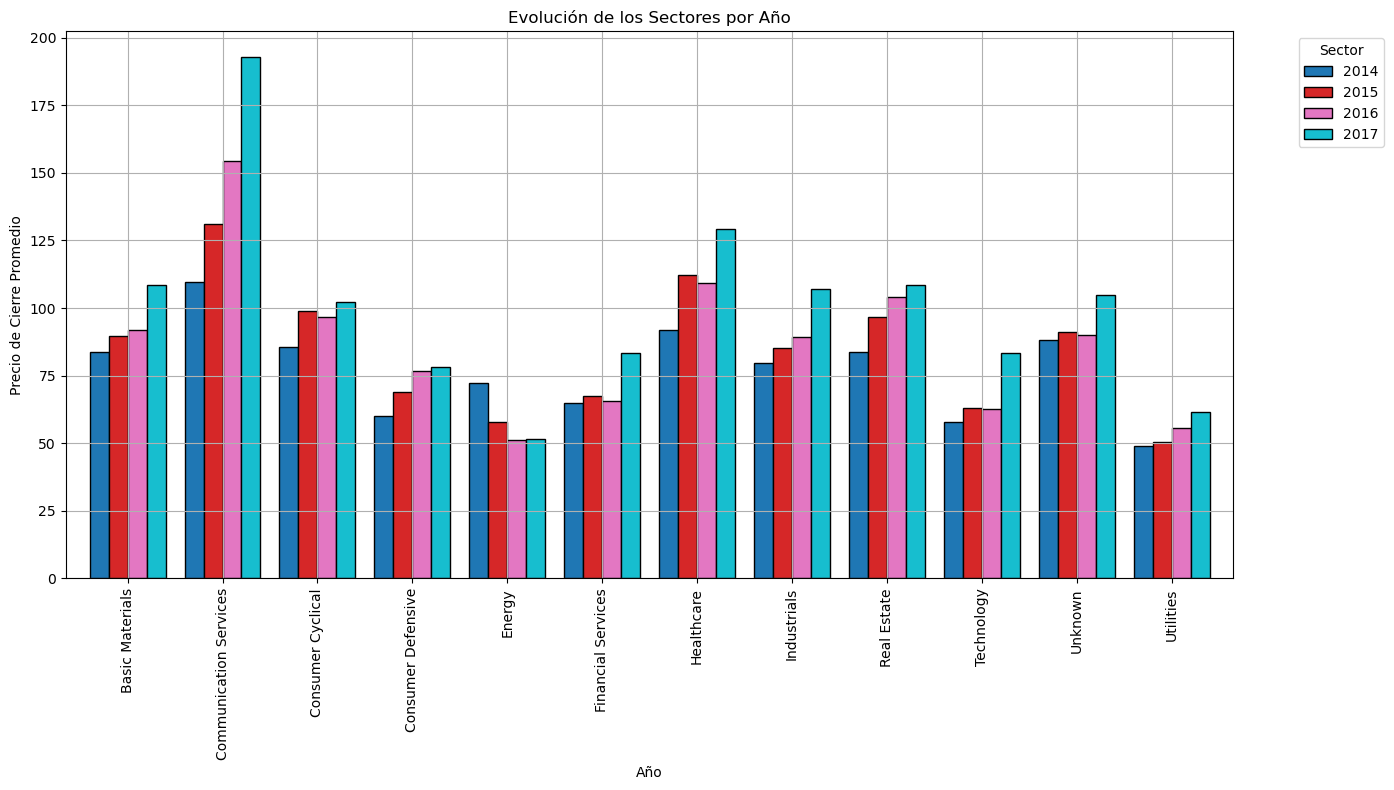

In [16]:
# Convertir la columna date a tipo datetime
data_limpio['date'] = pd.to_datetime(data_limpio['date'])
data_limpio['year'] = data_limpio['date'].dt.year

# Agrupar por sector y año, y calcular la media del precio de cierre
sector_yearly = data_limpio.groupby(['sector', 'year'])['close'].mean().unstack()

# Crear la gráfica de barras
plt.figure(figsize=(14, 8))
sector_yearly.plot(kind='bar', width=0.8, ax=plt.gca(), colormap='tab10', edgecolor='black')
plt.xlabel('Año')
plt.ylabel('Precio de Cierre Promedio')
plt.title('Evolución de los Sectores por Año')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\1135529311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpio['date'] = pd.to_datetime(data_limpio['date'])
C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\1135529311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpio['year'] = data_limpio['date'].dt.year


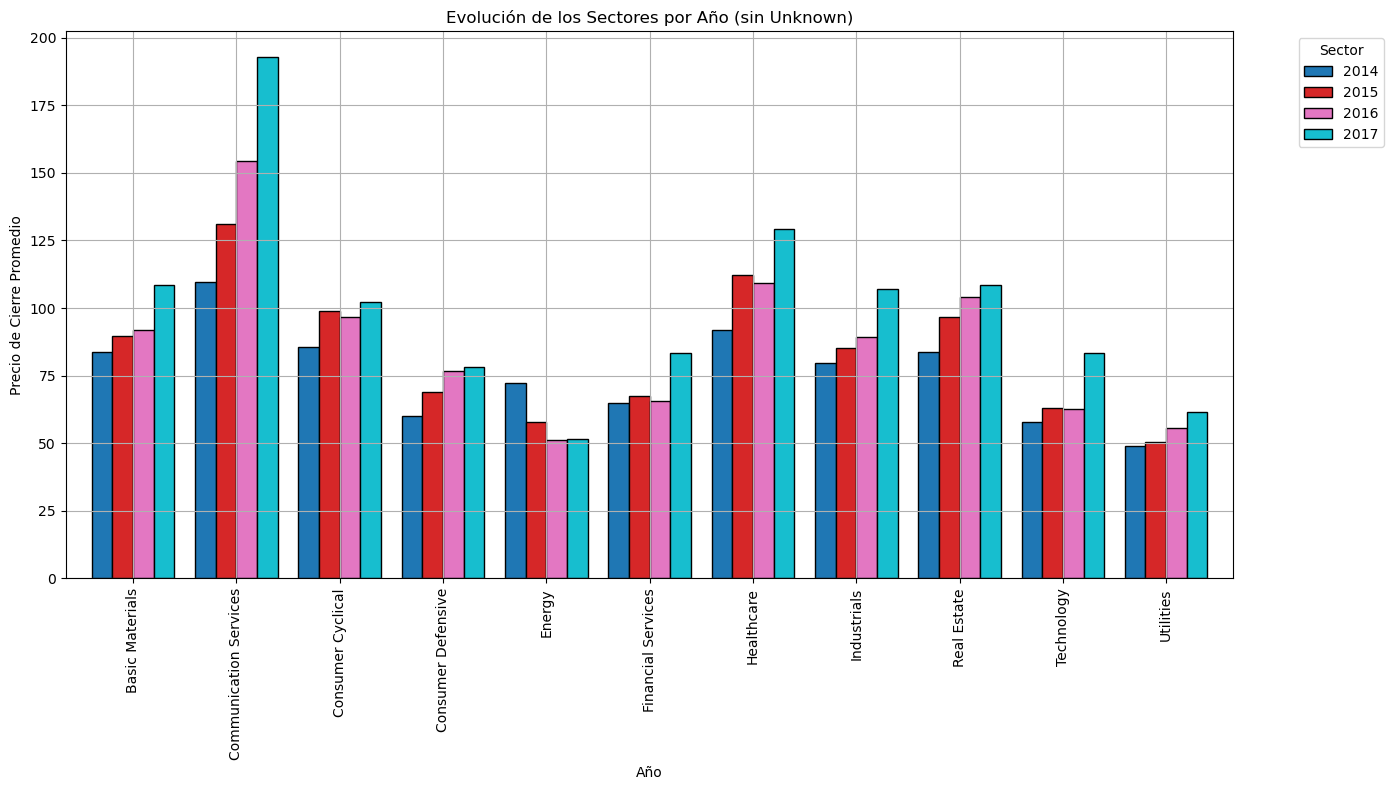

In [18]:
# Convertir la columna 'date' a tipo datetime y extraer el año
data_limpio['date'] = pd.to_datetime(data_limpio['date'])
data_limpio['year'] = data_limpio['date'].dt.year

# Filtrar los datos para excluir el sector 'Unknown'
data_filtered = data_limpio[data_limpio['sector'] != 'Unknown']

# Agrupar por sector y año, y calcular la media del precio de cierre
sector_yearly = data_filtered.groupby(['sector', 'year'])['close'].mean().unstack()

# Crear la gráfica de barras
plt.figure(figsize=(14, 8))
sector_yearly.plot(kind='bar', width=0.8, ax=plt.gca(), colormap='tab10', edgecolor='black')
plt.xlabel('Año')
plt.ylabel('Precio de Cierre Promedio')
plt.title('Evolución de los Sectores por Año (sin Unknown)')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# MODELAJE

## 1R MODELO

In [19]:
# Calcular el precio de cierre inicial y final para cada empresa
grouped = data.groupby('symbol').agg(
    initial_close=('close', 'first'),
    final_close=('close', 'last')
).reset_index()

# Calcular el crecimiento porcentual
grouped['growth'] = (grouped['final_close'] - grouped['initial_close']) / grouped['initial_close'] * 100

# Identificar la empresa con mayor y menor crecimiento
max_growth_symbol = grouped.loc[grouped['growth'].idxmax()]
min_growth_symbol = grouped.loc[grouped['growth'].idxmin()]

print("Empresa con mayor crecimiento:")
print(max_growth_symbol)

print("\nEmpresa con menor crecimiento:")
print(min_growth_symbol)

Empresa con mayor crecimiento:
symbol                  NVDA
initial_close          15.86
final_close            193.5
growth           1120.050441
Name: 346, dtype: object

Empresa con menor crecimiento:
symbol                 CHK
initial_close        26.62
final_close           3.96
growth          -85.123967
Name: 95, dtype: object


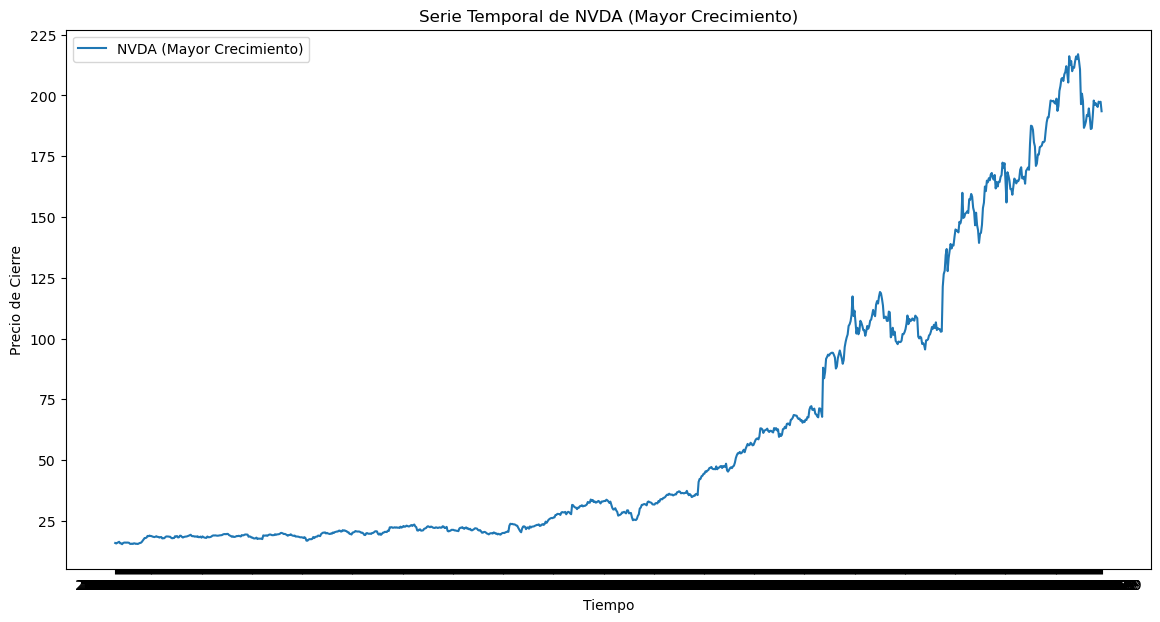

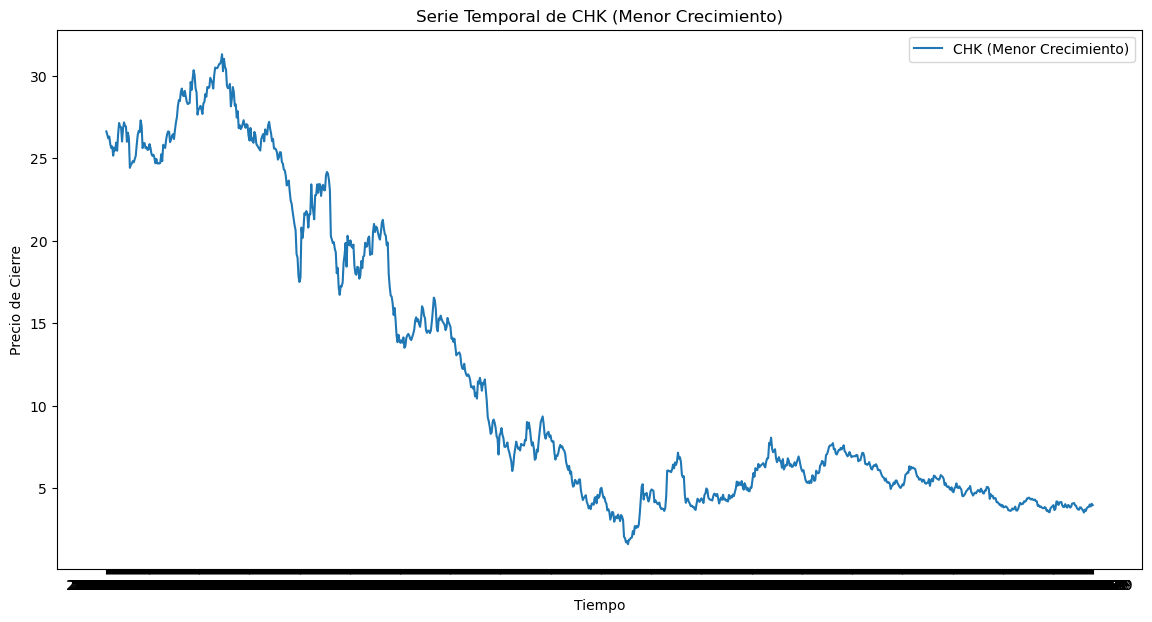

In [20]:
# Filtrar datos para las empresas con mayor y menor crecimiento
max_growth_data = data[data['symbol'] == max_growth_symbol['symbol']]
min_growth_data = data[data['symbol'] == min_growth_symbol['symbol']]

# Visualizar la empresa con mayor crecimiento
plt.figure(figsize=(14, 7))
plt.plot(max_growth_data['date'], max_growth_data['close'], label=f"{max_growth_symbol['symbol']} (Mayor Crecimiento)")
plt.title(f"Serie Temporal de {max_growth_symbol['symbol']} (Mayor Crecimiento)")
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

# Visualizar la empresa con menor crecimiento
plt.figure(figsize=(14, 7))
plt.plot(min_growth_data['date'], min_growth_data['close'], label=f"{min_growth_symbol['symbol']} (Menor Crecimiento)")
plt.title(f"Serie Temporal de {min_growth_symbol['symbol']} (Menor Crecimiento)")
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [21]:
def create_lagged_features(data, lags=5):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['close'].shift(lag)
    return data

# Crear características (lags) para la empresa con mayor crecimiento
lags = 100
max_growth_data = create_lagged_features(max_growth_data, lags).dropna().reset_index(drop=True)

# Dividir los datos en entrenamiento y prueba
training_size = int(len(max_growth_data) * 0.7)
train_data = max_growth_data[:training_size]
test_data = max_growth_data[training_size:]

# Separar las características (X) y el objetivo (y)
X_train = train_data[[f'lag_{i}' for i in range(1, lags + 1)]]
y_train = train_data['close']
X_test = test_data[[f'lag_{i}' for i in range(1, lags + 1)]]
y_test = test_data['close']

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\749351707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{lag}'] = data['close'].shift(lag)
C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\749351707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{lag}'] = data['close'].shift(lag)
C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\749351707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [22]:
# Entrenar el modelo de Random Forest
model_max_growth = RandomForestRegressor(n_estimators=100, random_state=42)
model_max_growth.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
# Hacer predicciones
train_predict_max = model_max_growth.predict(X_train)
test_predict_max = model_max_growth.predict(X_test)

# Calcular el error cuadrático medio (MSE)
train_mse_max = mean_squared_error(y_train, train_predict_max)
test_mse_max = mean_squared_error(y_test, test_predict_max)
print(f'MSE en el conjunto de entrenamiento (Mayor Crecimiento): {train_mse_max}')
print(f'MSE en el conjunto de prueba (Mayor Crecimiento): {test_mse_max}')

MSE en el conjunto de entrenamiento (Mayor Crecimiento): 0.14040237506897046
MSE en el conjunto de prueba (Mayor Crecimiento): 4486.80167735389


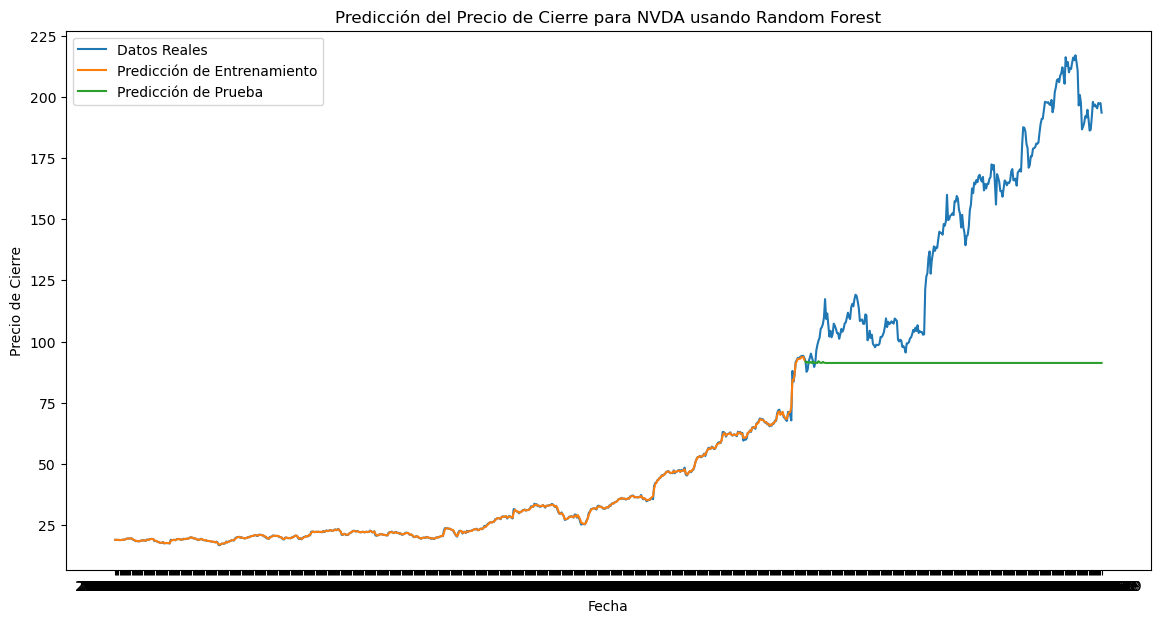

In [24]:
# Visualizar las predicciones para la empresa con mayor crecimiento
plt.figure(figsize=(14, 7))
plt.plot(max_growth_data['date'], max_growth_data['close'], label='Datos Reales')
plt.plot(train_data['date'], train_predict_max, label='Predicción de Entrenamiento')
plt.plot(test_data['date'], test_predict_max, label='Predicción de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title(f"Predicción del Precio de Cierre para {max_growth_symbol['symbol']} usando Random Forest")
plt.legend()
plt.show()

In [28]:
# Crear características (lags) para la empresa con menor crecimiento
min_growth_data = create_lagged_features(min_growth_data, lags).dropna().reset_index(drop=True)

# Dividir los datos en entrenamiento y prueba
training_size = int(len(min_growth_data) * 0.7)
train_data_min = min_growth_data[:training_size]
test_data_min = min_growth_data[training_size:]

# Separar las características (X) y el objetivo (y)
X_train_min = train_data_min[[f'lag_{i}' for i in range(1, lags + 1)]]
y_train_min = train_data_min['close']
X_test_min = test_data_min[[f'lag_{i}' for i in range(1, lags + 1)]]
y_test_min = test_data_min['close']

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\749351707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{lag}'] = data['close'].shift(lag)
C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\749351707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{lag}'] = data['close'].shift(lag)
C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\749351707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [29]:
# Entrenar el modelo de Random Forest
model_min_growth = RandomForestRegressor(n_estimators=100, random_state=42)
model_min_growth.fit(X_train_min, y_train_min)

RandomForestRegressor(random_state=42)

In [30]:
# Hacer predicciones
train_predict_min = model_min_growth.predict(X_train_min)
test_predict_min = model_min_growth.predict(X_test_min)

# Calcular el error cuadrático medio (MSE)
train_mse_min = mean_squared_error(y_train_min, train_predict_min)
test_mse_min = mean_squared_error(y_test_min, test_predict_min)
print(f'MSE en el conjunto de entrenamiento (Menor Crecimiento): {train_mse_min}')
print(f'MSE en el conjunto de prueba (Menor Crecimiento): {test_mse_min}')

MSE en el conjunto de entrenamiento (Menor Crecimiento): 0.032968567902208396
MSE en el conjunto de prueba (Menor Crecimiento): 0.060283628095238115


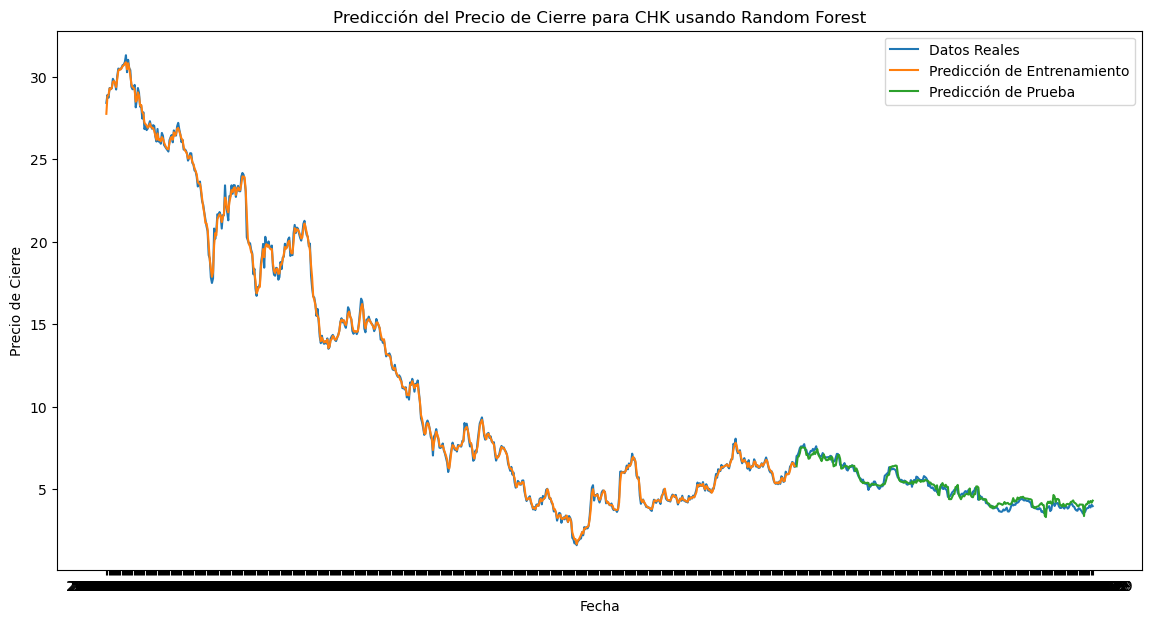

In [31]:
# Visualizar las predicciones para la empresa con menor crecimiento
plt.figure(figsize=(14, 7))
plt.plot(min_growth_data['date'], min_growth_data['close'], label='Datos Reales')
plt.plot(train_data_min['date'], train_predict_min, label='Predicción de Entrenamiento')
plt.plot(test_data_min['date'], test_predict_min, label='Predicción de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title(f"Predicción del Precio de Cierre para {min_growth_symbol['symbol']} usando Random Forest")
plt.legend()
plt.show()

In [32]:
# Filtrar datos para incluir solo el último año disponible
one_year_ago = data_limpio['date'].max() - pd.DateOffset(years=1)
df_last_year = data_limpio[data_limpio['date'] > one_year_ago]

# Calcular la variación porcentual del precio de cierre
df_last_year['pct_change'] = df_last_year.groupby('symbol')['close'].pct_change()
mean_pct_change = df_last_year.groupby('symbol')['pct_change'].mean()

# Identificar la empresa con mejor rendimiento
best_performing_symbol = mean_pct_change.idxmax()
print(f"La empresa con mejor rendimiento es: {best_performing_symbol}")

La empresa con mejor rendimiento es: NRG


C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\3698512587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_year['pct_change'] = df_last_year.groupby('symbol')['close'].pct_change()


In [33]:
# Filtrar los datos para la empresa con mejor rendimiento
best_company_data = df_last_year[df_last_year['symbol'] == best_performing_symbol].copy()

# Crear la característica del rango diario (diferencia entre el máximo y el mínimo)
best_company_data['range'] = best_company_data['high'] - best_company_data['low']

# Crear características (lags)
lags = 5
for lag in range(1, lags + 1):
    best_company_data[f'lag_{lag}'] = best_company_data['range'].shift(lag)

# Eliminar filas con valores NaN
best_company_data = best_company_data.dropna().reset_index(drop=True)

# Separar las características (X) y el objetivo (y)
X = best_company_data[[f'lag_{i}' for i in range(1, lags + 1)]]
y = best_company_data['range']

# Dividir los datos en entrenamiento y prueba
training_size = int(len(best_company_data) * 0.7)
X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]

MSE en el conjunto de entrenamiento: 0.011696661230081383
MSE en el conjunto de prueba: 0.08453469585920005


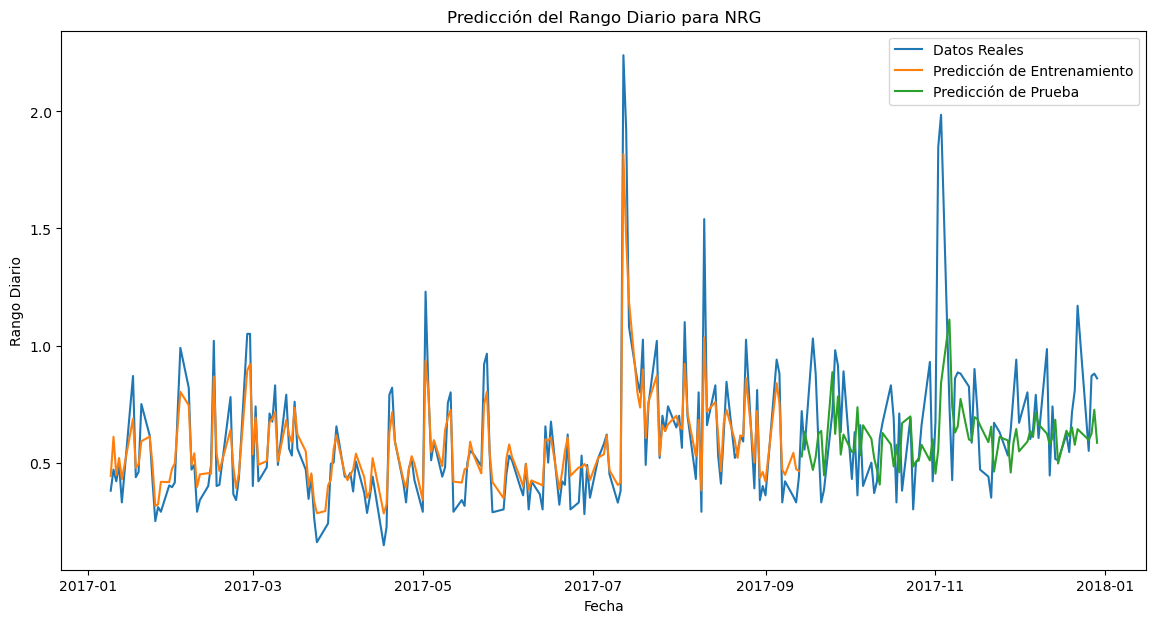

In [34]:
# Entrenar el modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(f'MSE en el conjunto de entrenamiento: {train_mse}')
print(f'MSE en el conjunto de prueba: {test_mse}')

# Visualizar las predicciones
plt.figure(figsize=(14, 7))
plt.plot(best_company_data['date'], best_company_data['range'], label='Datos Reales')
plt.plot(best_company_data['date'][:training_size], train_predict, label='Predicción de Entrenamiento')
plt.plot(best_company_data['date'][training_size:], test_predict, label='Predicción de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Rango Diario')
plt.title(f"Predicción del Rango Diario para {best_performing_symbol}")
plt.legend()
plt.show()

## SEGUNDO MODELO

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\3772524207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tech_data['performance'] = (tech_data['close'] - tech_data['open']) / tech_data['open']
20:10:02 - cmdstanpy - INFO - Chain [1] start processing
20:10:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophe

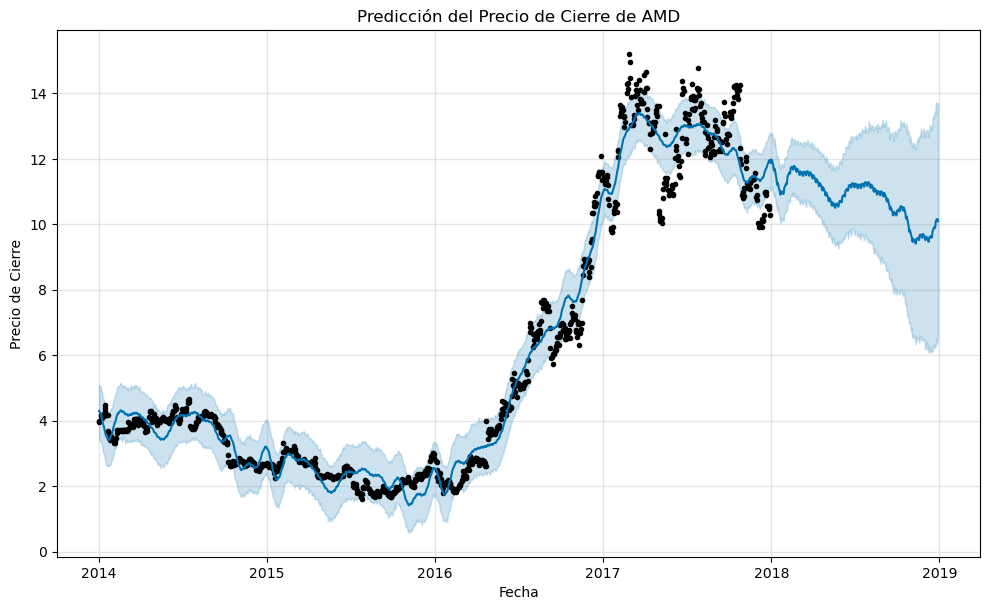

c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

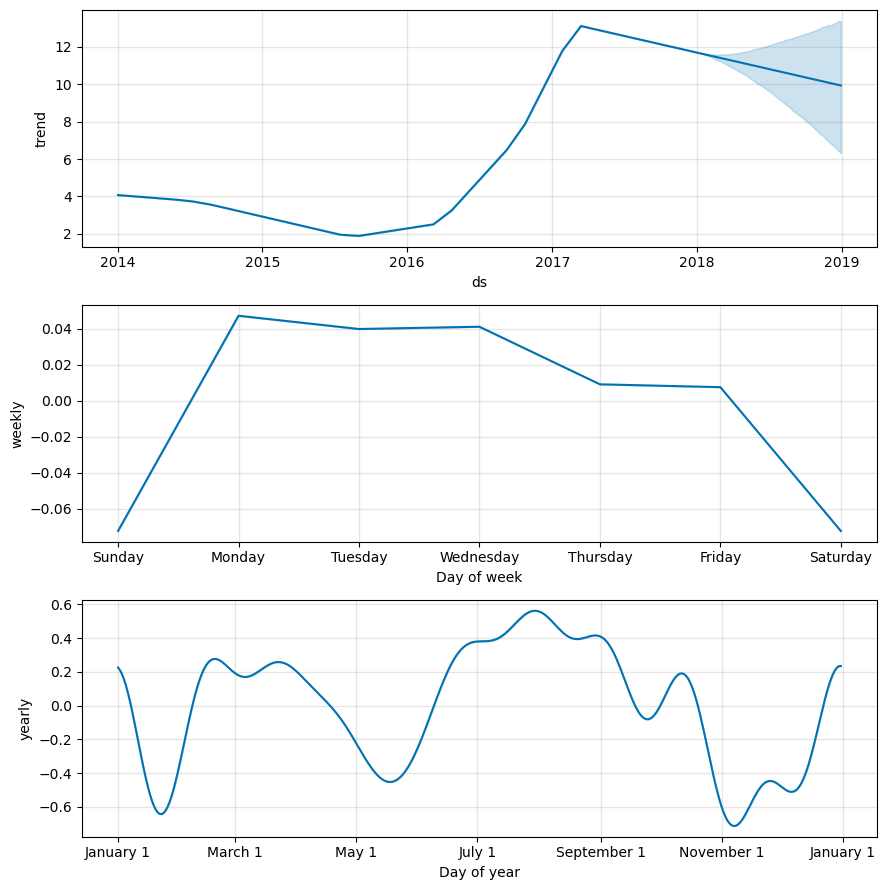

MSE: 0.4074714479384009
R^2: 0.9765019580241759


In [35]:
# Filtrar los datos para el sector 'Technology'
tech_data = data_limpio[data_limpio['sector'] == 'Technology']

# Calcular el rendimiento para cada empresa en el sector 'Technology'
tech_data['performance'] = (tech_data['close'] - tech_data['open']) / tech_data['open']

# Seleccionar la empresa con el mejor rendimiento
best_tech_company = tech_data.loc[tech_data['performance'].idxmax()]

# Filtrar los datos para la empresa con mejor rendimiento
best_company_symbol = best_tech_company['symbol']
best_company_data = data_limpio[data_limpio['symbol'] == best_company_symbol]

# Formatear los datos para Prophet
best_company_data = best_company_data.rename(columns={'date': 'ds', 'close': 'y'})

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(best_company_data[['ds', 'y']])

# Hacer predicciones para los próximos 365 días
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Graficar las predicciones
fig = model.plot(forecast)
plt.title(f'Predicción del Precio de Cierre de {best_company_symbol}')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.show()

# Graficar los componentes del modelo para entender el crecimiento
fig2 = model.plot_components(forecast)
plt.show()

# Calcular MSE y R^2
y_true = best_company_data['y'].values
y_pred = forecast['yhat'].iloc[:len(y_true)].values

# Calcular MSE
mse = mean_squared_error(y_true, y_pred)

# Calcular R^2
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse}')
print(f'R^2: {r2}')

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\4167609469.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_services_data['performance'] = (comm_services_data['close'] - comm_services_data['open']) / comm_services_data['open']
20:11:07 - cmdstanpy - INFO - Chain [1] start processing
20:11:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambien

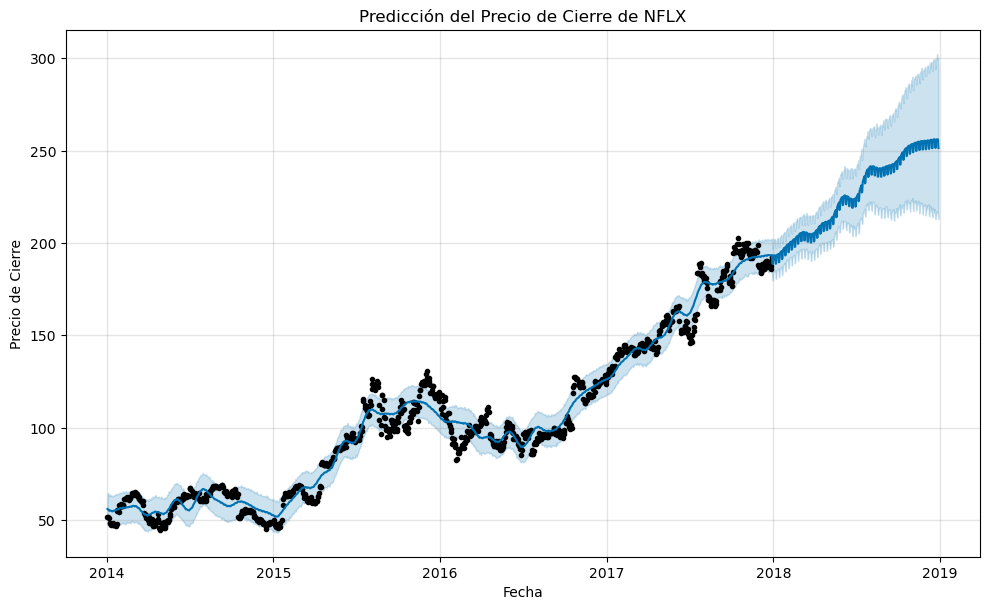

c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

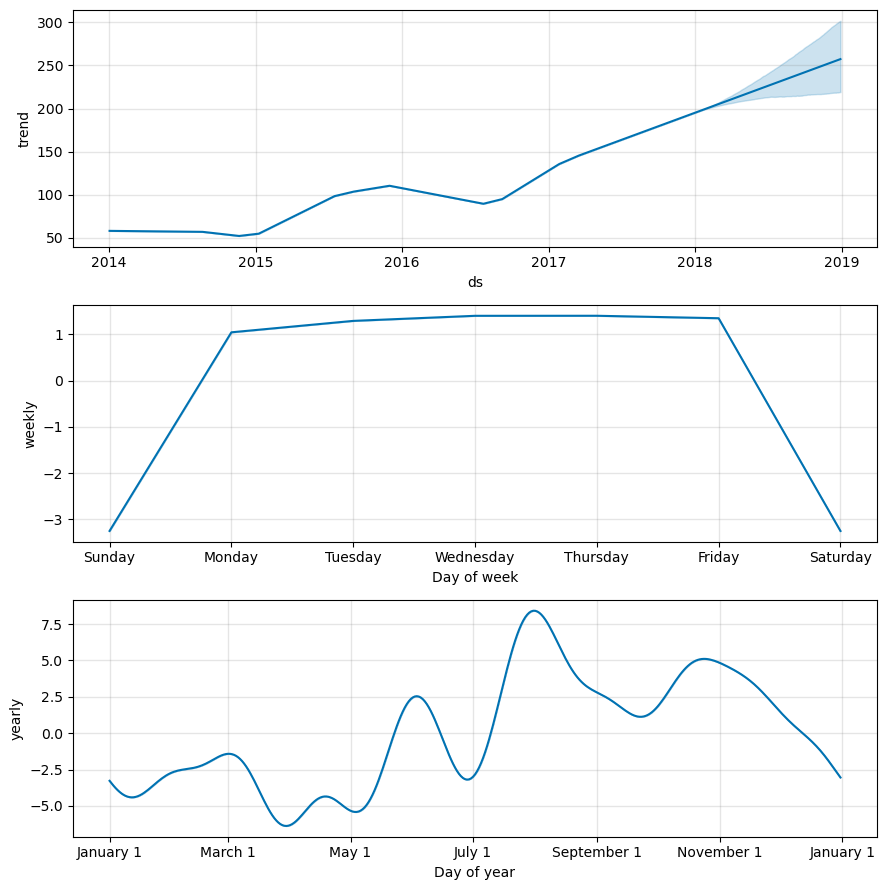

MSE: 43.140732900534594
R^2: 0.9761427910980013


In [36]:
# Filtrar los datos para el sector 'Communication Services'
comm_services_data = data_limpio[data_limpio['sector'] == 'Communication Services']

# Calcular el rendimiento para cada empresa en el sector 'Communication Services'
comm_services_data['performance'] = (comm_services_data['close'] - comm_services_data['open']) / comm_services_data['open']

# Seleccionar la empresa con el mejor rendimiento
best_comm_services_company = comm_services_data.loc[comm_services_data['performance'].idxmax()]

# Filtrar los datos para la empresa con mejor rendimiento
best_company_symbol = best_comm_services_company['symbol']
best_company_data = data_limpio[data_limpio['symbol'] == best_company_symbol]

# Formatear los datos para Prophet
best_company_data = best_company_data.rename(columns={'date': 'ds', 'close': 'y'})

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(best_company_data[['ds', 'y']])

# Hacer predicciones para los próximos 365 días
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Graficar las predicciones
fig = model.plot(forecast)
plt.title(f'Predicción del Precio de Cierre de {best_company_symbol}')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.show()

# Graficar los componentes del modelo para entender el crecimiento
fig2 = model.plot_components(forecast)
plt.show()

# Calcular MSE y R^2
y_true = best_company_data['y'].values
y_pred = forecast['yhat'].iloc[:len(y_true)].values

# Calcular MSE
mse = mean_squared_error(y_true, y_pred)

# Calcular R^2
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse}')
print(f'R^2: {r2}')

Volatilidad Histórica de AAPL: 1332072.7724623904


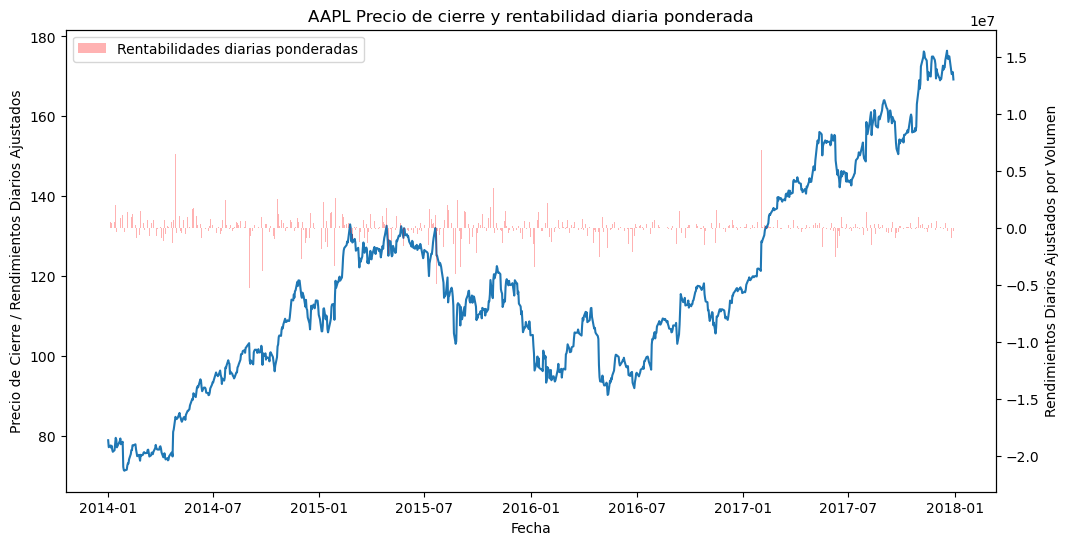

In [37]:
# Filtrar los datos para una empresa específica del sector deseado (por ejemplo, 'AAPL' en 'Technology')
company_symbol = 'AAPL'
sector = 'Technology'
company_data = data_limpio[(data_limpio['symbol'] == company_symbol) & (data_limpio['sector'] == sector)]

# Seleccionar las columnas relevantes: fecha, precio de cierre y volumen
company_data = company_data[['date', 'close', 'volume']]

# Convertir la columna de fecha al formato datetime y establecerla como índice
company_data['date'] = pd.to_datetime(company_data['date'])
company_data.set_index('date', inplace=True)

# Calcular los rendimientos diarios
company_data['daily_returns'] = company_data['close'].pct_change()

# Ajustar la volatilidad por volumen (ponderación por volumen)
company_data['weighted_daily_returns'] = company_data['daily_returns'] * company_data['volume']

# Calcular la volatilidad histórica (desviación estándar de los rendimientos ajustados por volumen)
historical_volatility = np.std(company_data['weighted_daily_returns'], ddof=1)

print(f'Volatilidad Histórica de {company_symbol}: {historical_volatility}')

# Graficar los precios de cierre y los rendimientos diarios ajustados por volumen
plt.figure(figsize=(12, 6))
plt.plot(company_data.index, company_data['close'], label='Closing Price')
plt.title(f'{company_symbol} Precio de cierre y rentabilidad diaria ponderada')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre / Rendimientos Diarios Ajustados')
plt.twinx()
plt.bar(company_data.index, company_data['weighted_daily_returns'], alpha=0.3, color='red', label='Rentabilidades diarias ponderadas')
plt.ylabel('Rendimientos Diarios Ajustados por Volumen')
plt.legend(loc='upper left')
plt.show()

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\2849336993.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_data['date'] = pd.to_datetime(sector_data['date'])
C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\2849336993.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_data['daily_returns'] = sector_data.groupby('sector')['close'].pct_change()
C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\2849336993.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

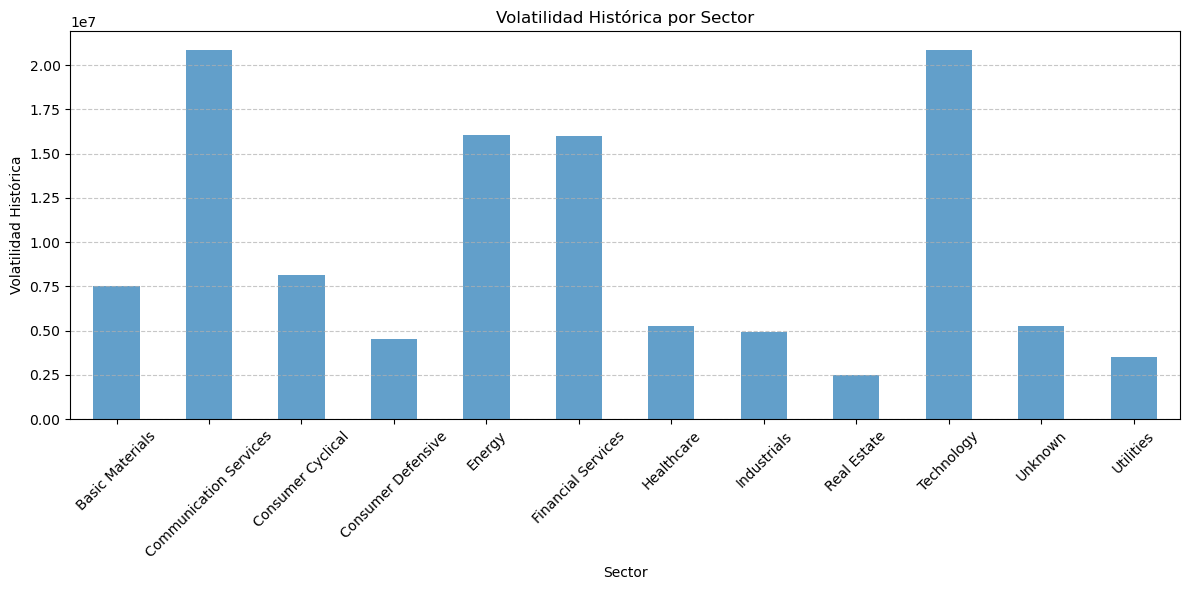

Volatilidad Histórica por Sector:
sector
Basic Materials           7.532541e+06
Communication Services    2.084964e+07
Consumer Cyclical         8.123743e+06
Consumer Defensive        4.544541e+06
Energy                    1.602792e+07
Financial Services        1.598507e+07
Healthcare                5.245089e+06
Industrials               4.904887e+06
Real Estate               2.506868e+06
Technology                2.086114e+07
Unknown                   5.232614e+06
Utilities                 3.485161e+06
Name: weighted_daily_returns, dtype: float64


In [38]:
# Seleccionar las columnas relevantes: sector, fecha, precio de cierre y volumen
sector_data = data_limpio[['sector', 'date', 'close', 'volume']]

# Convertir la columna de fecha al formato datetime
sector_data['date'] = pd.to_datetime(sector_data['date'])

# Calcular los rendimientos diarios para cada empresa dentro de cada sector
sector_data['daily_returns'] = sector_data.groupby('sector')['close'].pct_change()

# Ajustar la volatilidad por volumen (ponderación por volumen)
sector_data['weighted_daily_returns'] = sector_data['daily_returns'] * sector_data['volume']

# Calcular la volatilidad histórica por sector (desviación estándar de los rendimientos diarios ajustados por volumen)
historical_volatility_by_sector = sector_data.groupby('sector')['weighted_daily_returns'].std()

# Graficar la volatilidad histórica por sector
plt.figure(figsize=(12, 6))
historical_volatility_by_sector.plot(kind='bar', alpha=0.7)
plt.title('Volatilidad Histórica por Sector')
plt.xlabel('Sector')
plt.ylabel('Volatilidad Histórica')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar la volatilidad histórica por sector
print('Volatilidad Histórica por Sector:')
print(historical_volatility_by_sector)

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\2123408318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpio_volume['date'] = pd.to_datetime(data_limpio_volume['date'])
20:15:53 - cmdstanpy - INFO - Chain [1] start processing
20:15:59 - cmdstanpy - INFO - Chain [1] done processing
20:16:01 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:11 - cmdstanpy - INFO - Chain [1] start processing
20:16:14 - cmdstanpy - INFO - Chain [1] done processing
20:16:17 - cmdstanpy - INFO - Chain [1] start processing
20:16:29 - cmdstanpy - INFO - Chain [1] done processing
20:16:32 - cmdstanpy - INFO - Chain [1] start processing
20:16:40 - cmdstanpy - INFO - Chain [1] done processing
20:16:

El sector con mayor crecimiento esperado es: Communication Services
Tasa de crecimiento esperada: 125.74%


20:18:06 - cmdstanpy - INFO - Chain [1] start processing
20:18:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


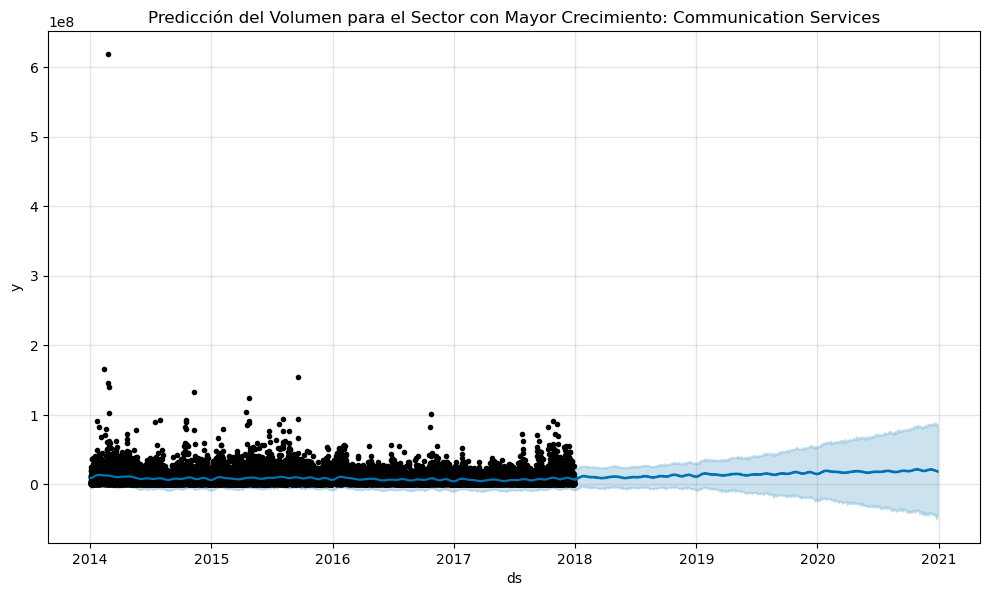

In [39]:
# Cargar y preparar datos
data_limpio_volume = data_limpio[['date', 'volume', 'sector']]
data_limpio_volume['date'] = pd.to_datetime(data_limpio_volume['date'])
df_volume = data_limpio_volume.rename(columns={'date': 'ds', 'volume': 'y'})

# Obtener la lista de sectores únicos
sectors = df_volume['sector'].unique()

# Crear un diccionario para almacenar modelos y pronósticos
growth_rates = {}

for sector in sectors:
    # Filtrar datos por sector
    df_sector = df_volume[df_volume['sector'] == sector]
    
    # Crear y ajustar el modelo Prophet
    model = Prophet()
    model.fit(df_sector)
    
    # Crear un DataFrame para fechas futuras (por ejemplo, los próximos 3 años)
    future = model.make_future_dataframe(periods=3*365)
    
    # Predecir
    forecast = model.predict(future)
    
    # Calcular la tasa de crecimiento
    # Aquí usamos la diferencia en el promedio de los volúmenes futuros como una métrica simple
    future_mean_volume = forecast['yhat'][-365:].mean()  # Promedio de los últimos 365 días de predicciones
    past_mean_volume = df_sector['y'].mean()  # Promedio histórico
    
    growth_rate = (future_mean_volume - past_mean_volume) / past_mean_volume
    growth_rates[sector] = growth_rate

# Encontrar el sector con el mayor crecimiento
max_growth_sector = max(growth_rates, key=growth_rates.get)
max_growth_rate = growth_rates[max_growth_sector]

print(f"El sector con mayor crecimiento esperado es: {max_growth_sector}")
print(f"Tasa de crecimiento esperada: {max_growth_rate:.2%}")

# Graficar resultados para el sector con mayor crecimiento
df_best_sector = df_volume[df_volume['sector'] == max_growth_sector]
model_best = Prophet()
model_best.fit(df_best_sector)
future_best = model_best.make_future_dataframe(periods=3*365)
forecast_best = model_best.predict(future_best)

fig = model_best.plot(forecast_best)
plt.title(f'Predicción del Volumen para el Sector con Mayor Crecimiento: {max_growth_sector}')
plt.show()

C:\Users\Pavel\AppData\Local\Temp\ipykernel_21316\3269489059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpio_volume['date'] = pd.to_datetime(data_limpio_volume['date'])
20:18:57 - cmdstanpy - INFO - Chain [1] start processing
20:19:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:73: Fu

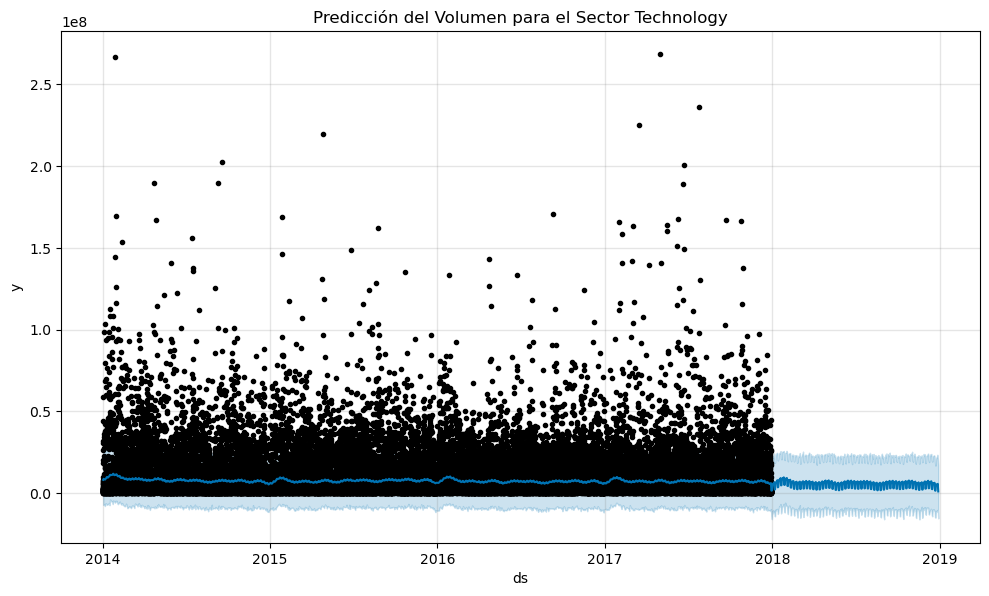

Volatilidad predicha para el sector Technology: 31.96%


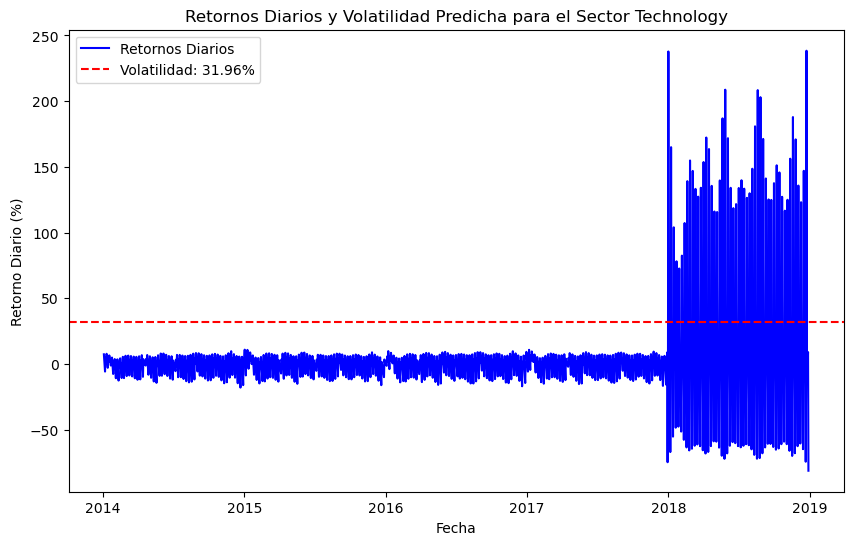

In [40]:
# Cargar y preparar datos
data_limpio_volume = data_limpio[['date', 'volume', 'sector']]
data_limpio_volume['date'] = pd.to_datetime(data_limpio_volume['date'])
data_limpio_volume = data_limpio_volume.rename(columns={'date': 'ds', 'volume': 'y'})

# Filtrar datos para el sector Technology
data_limpio_technology = data_limpio_volume[df_volume['sector'] == 'Technology']

# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(data_limpio_technology)

# Crear un DataFrame para fechas futuras (por ejemplo, los próximos 365 días)
future = model.make_future_dataframe(periods=365)

# Predecir
forecast = model.predict(future)

# Graficar resultados
fig = model.plot(forecast)
plt.title('Predicción del Volumen para el Sector Technology')
plt.show()

# Calcular volatilidad
# Calculamos la volatilidad a partir de las predicciones de volumen
# Volatilidad como desviación estándar de los retornos porcentuales diarios

# Extraer valores predichos
predicted_volumes = forecast['yhat'].values
dates = forecast['ds']

# Calcular retornos porcentuales diarios
returns = 100 * np.diff(predicted_volumes) / predicted_volumes[:-1]

# Calcular la desviación estándar (volatilidad)
volatility = np.std(returns)

print(f"Volatilidad predicha para el sector Technology: {volatility:.2f}%")

# Graficar la volatilidad de las predicciones
plt.figure(figsize=(10, 6))
plt.plot(dates[1:], returns, label='Retornos Diarios', color='blue')
plt.axhline(y=volatility, color='red', linestyle='--', label=f'Volatilidad: {volatility:.2f}%')
plt.title('Retornos Diarios y Volatilidad Predicha para el Sector Technology')
plt.xlabel('Fecha')
plt.ylabel('Retorno Diario (%)')
plt.legend()
plt.show()

20:20:42 - cmdstanpy - INFO - Chain [1] start processing
20:20:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


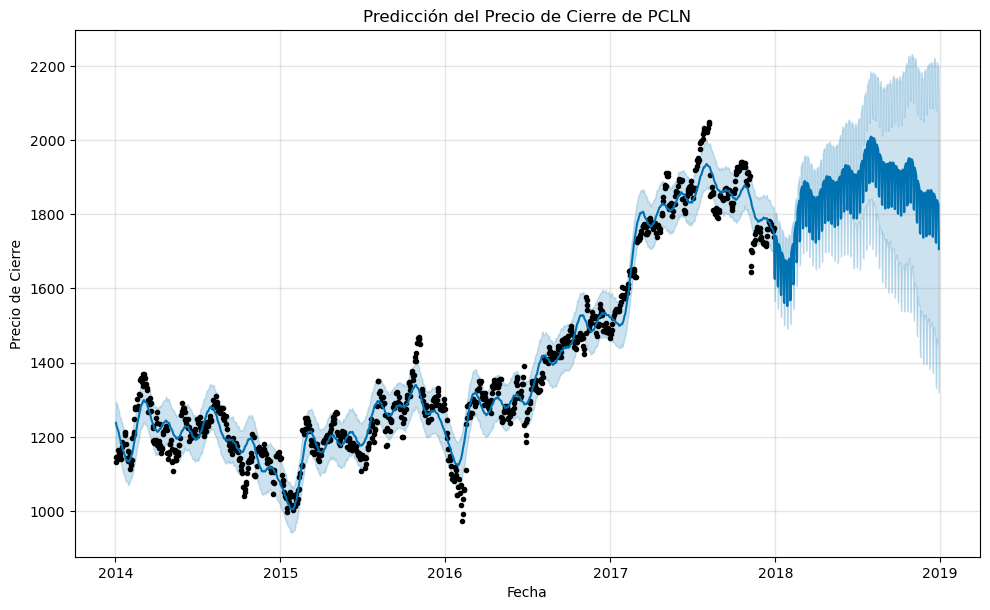

20:20:43 - cmdstanpy - INFO - Chain [1] start processing
20:20:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


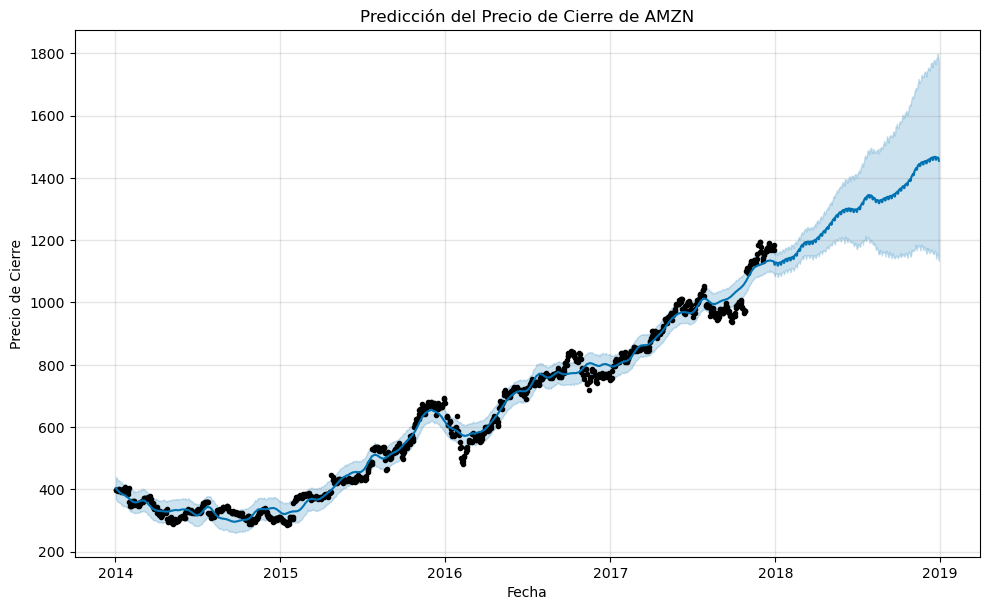

20:20:44 - cmdstanpy - INFO - Chain [1] start processing
20:20:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


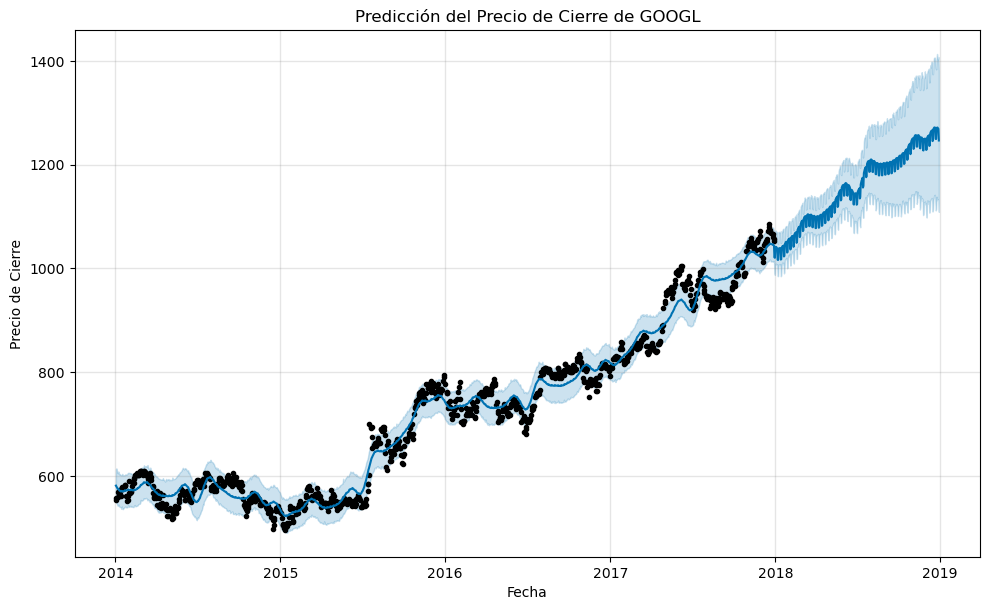

20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


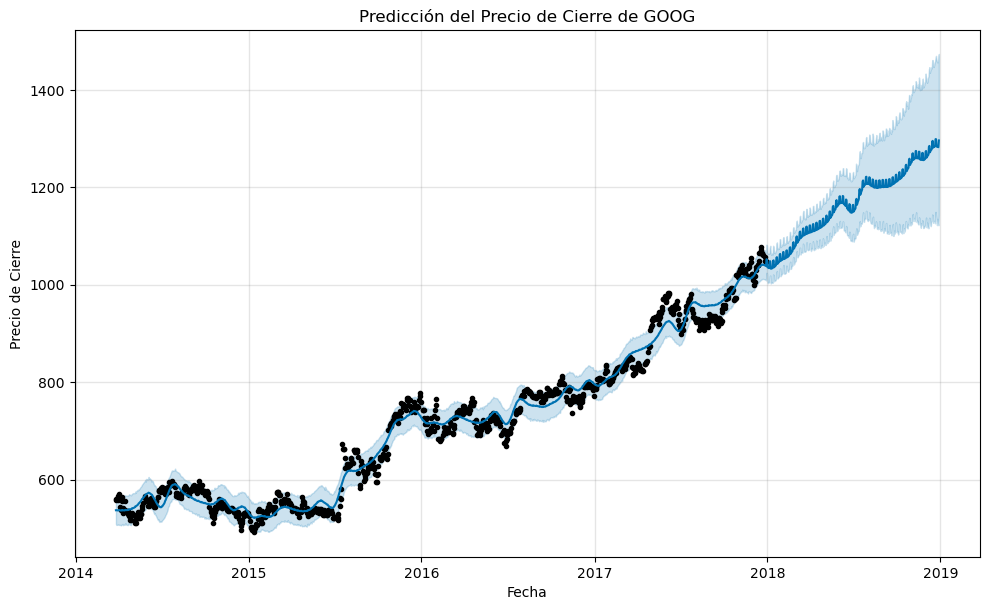

20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Pavel\miniconda3\envs\ambiente_proyecto\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


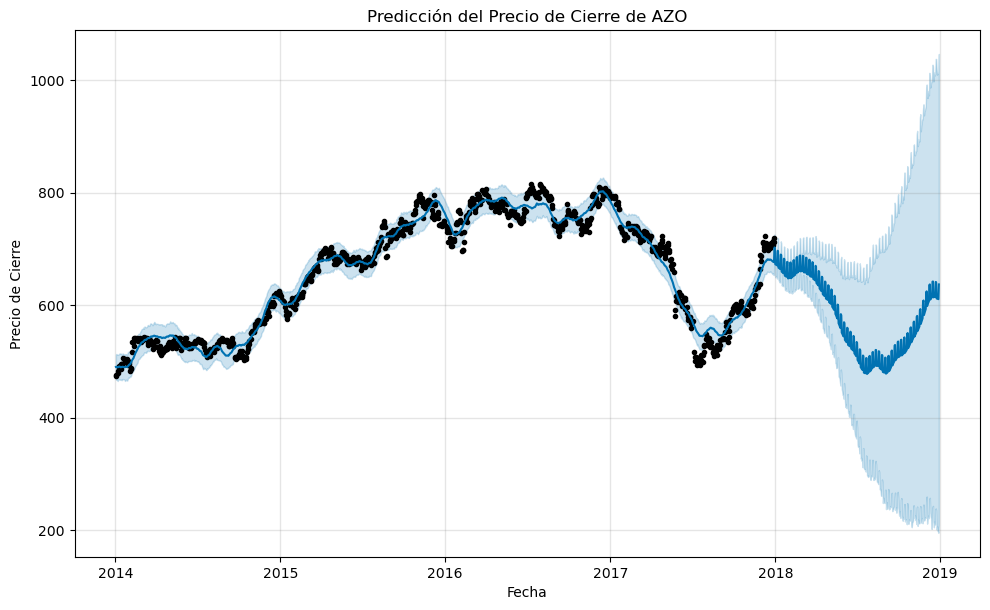

In [41]:
# Lista de símbolos a predecir
symbols = ['PCLN', 'AMZN', 'GOOGL', 'GOOG', 'AZO']

# Crear un DataFrame vacío para almacenar las predicciones
predictions = pd.DataFrame()

for symbol in symbols:
    # Filtrar los datos para la empresa actual
    company_data = data_limpio[data_limpio['symbol'] == symbol]

    # Formatear los datos para Prophet
    company_data = company_data.rename(columns={'date': 'ds', 'close': 'y'})

    # Crear y entrenar el modelo Prophet
    model = Prophet()
    model.fit(company_data[['ds', 'y']])

    # Hacer predicciones para los próximos 365 días
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)

    # Añadir las predicciones al DataFrame de predicciones
    forecast['symbol'] = symbol
    predictions = pd.concat([predictions, forecast[['ds', 'yhat', 'symbol']]], ignore_index=True)

    # Graficar las predicciones
    fig = model.plot(forecast)
    plt.title(f'Predicción del Precio de Cierre de {symbol}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.show()

In [65]:
for symbol in symbols:
    # Filtrar las predicciones y los datos históricos
    company_data = data_limpio[data_limpio['symbol'] == symbol]
    company_data = company_data.rename(columns={'date': 'ds', 'close': 'y'})
    forecast = predictions[predictions['symbol'] == symbol]

    # Alinear los valores reales y las predicciones
    y_true = company_data['y'].values
    y_pred = forecast['yhat'].iloc[:len(y_true)].values

    # Calcular MSE y R^2
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f'{symbol} - MSE: {mse}, R^2: {r2}')

PCLN - MSE: 2243.155686828558, R^2: 0.9677926533234605
AMZN - MSE: 739.8889824843568, R^2: 0.9887386264641936
GOOGL - MSE: 610.6525827699583, R^2: 0.9751647260617032
GOOG - MSE: 525.862772890894, R^2: 0.978019098952625
AZO - MSE: 316.44131455884565, R^2: 0.9688686993599719
